In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import bids
from bids import BIDSLayout, BIDSValidator
from tqdm import tqdm

import nilearn as nil

from nilearn.image import resample_to_img, resample_img
from nilearn.datasets import load_mni152_template, load_mni152_brain_mask
from nilearn.glm.first_level.hemodynamic_models import compute_regressor
import nibabel as nib

from skimage.measure import block_reduce
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

from scipy.stats import ttest_1samp, ttest_ind, t, sem
import hbayesdm.models

from concurrent.futures import ProcessPoolExecutor

import model_based_mvpa as mbmvpa
from model_based_mvpa.preprocessing.bids import *
from model_based_mvpa.preprocessing.events import *
from model_based_mvpa.utils.func import *

import matplotlib.pyplot as plt

In [2]:
bids.config.set_option('extension_initial_dot', True)

args = {
    'root': '/data2/project_model_based_fmri/ds000005/',
}

In [4]:
X, masked_data = bids_preprocess(args['root'], single_file=True, smoothing_fwhm=None, zoom=(2, 2, 2), ncore=os.cpu_count())

        bids preprocessing done!        : 100%|██████████| 4/4 [00:54<00:00, 13.62s/it]

(46, 55, 46)
(6810,)
time elapsed: 54.48217535018921 seconds
time elapsed: 54.48903965950012


In [3]:
funcs = [adjust_event_columns, calculate_modulation]

In [4]:
a, b, y = preprocess_events(args['root'], dm_model='ra_prospect', funcs=funcs, ncore=4)

      hbayesdm doing (model: ra_prospect)..      :  33%|███▎      | 2/6 [00:14<00:40, 10.12s/it]INFO:numexpr.utils:Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Using cached StanModel: cached-ra_prospect-pystan_2.19.1.1.pkl



Model  = ra_prospect
Data   = <pandas.DataFrame object>

Details:
 # of chains                    = 4
 # of cores used                = 4
 # of MCMC samples (per chain)  = 4000
 # of burn-in samples           = 1000
 # of subjects                  = 16
 # of (max) trials per subject  = 256

Using cached StanModel: cached-ra_prospect-pystan_2.19.1.1.pkl


       modulation signal making..       :  67%|██████▋   | 4/6 [34:41<20:54, 627.14s/it]         

Index(['onset', 'duration', 'parametric loss', 'distance from indifference',
       'parametric gain', 'gain', 'loss', 'ptval', 'respnum', 'respcat',
       'responsetime', 'run', 'subjid', 'gamble', 'cert'],
      dtype='object')
['onset', 'duration', 'parametric loss', 'distance from indifference', 'parametric gain', 'gain', 'loss', 'PTval', 'respnum', 'respcat', 'response_time', 'run', 'subjID', 'gamble', 'cert']
************************************
**** Model fitting is complete! ****
************************************


       events preproecssing done!       : 100%|██████████| 6/6 [34:41<00:00, 346.98s/it]

time elapsed: 2081.8706233501434 seconds


In [7]:
X = np.load('/data2/project_model_based_fmri/ds000005/derivatives/fmriprep/data/X.npy')
y = np.load('/data2/project_model_based_fmri/ds000005/derivatives/fmriprep/data/y.npy')
print(X.shape, y.shape)

(16, 3, 240, 6810) (16, 3, 240, 1)


In [24]:
X, y = prepare_data(X, y)

In [25]:
X.shape, y.shape

((11520, 6810), (11520, 1))

In [9]:
import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras import Sequential, layers, losses, optimizers, datasets
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

In [10]:
class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(X.shape[0])
        self.on_epoch_end()
        
    # for printing the statistics of the function
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        "Denotes the number of batches per epoch"
        
        return int(np.floor(len(self.indexes) / self.batch_size))

    def __getitem__(self, index):  # index : batch no.
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        niis = [X[i] for i  in indexes]
        targets = [y[i] for i in indexes]
        niis = np.array(niis)
        targets = np.array(targets)

        return niis, targets  # return batch

In [37]:
alpha = 0.001
lambda_par = 0
repeat_N = 100
batch_size = 64
epochs = 100

In [12]:
X.shape, y.shape

((16, 3, 240, 6810), (16, 3, 240, 1))

In [13]:
X = X.reshape(48 * 240, -1)
y = y.reshape(48 * 240, -1)
print(X.shape, y.shape)

(11520, 6810) (11520, 1)


In [24]:
X.max(), X.min()

(14.463965189594633, -15.18786072305404)

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 1., 0., 0.],
        [0., 0., 2., ..., 1., 0., 0.],
        [0., 0., 1., ..., 1., 0., 0.]]),
 array([-15.18786072, -12.22267813,  -9.25749554,  -6.29231295,
         -3.32713036,  -0.36194777,   2.60323482,   5.56841742,
          8.53360001,  11.4987826 ,  14.46396519]),
 <a list of 6810 BarContainer objects>)

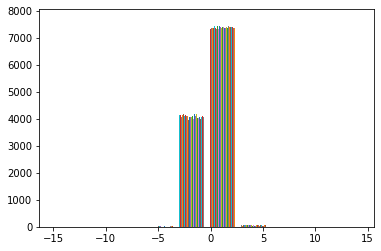

In [25]:
plt.hist(X)

In [38]:
coeffs = []

for repeat_i in range(repeat_N):
    ids = np.arange(X.shape[0])
    train_ids, test_ids = train_test_split(ids, test_size=0.2, random_state=42 + repeat_i)
    train_steps = len(train_ids) // batch_size
    valid_steps = len(test_ids) // batch_size

    X_train = X[train_ids]
    y_train = y[train_ids]
    X_test = X[test_ids]
    y_test = y[test_ids]
    
    train_generator = DataGenerator(X_train, y_train, batch_size, shuffle=True)
    valid_generator = DataGenerator(X_test, y_test, batch_size, shuffle=False)
    
    bst_model_path = f'ml_models/{repeat_i}_best_elasticnet_alpha{alpha:0.3f}_lambda{lambda_par:0.2f}.h5'
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True,monitor='val_loss',mode='min',)
    
    model = Sequential()
    model.add(Dense(1, activation='linear', input_shape=(X.shape[-1],),
                    use_bias=True,
                    kernel_regularizer=l1_l2(lambda_par*alpha,lambda_par*(1-alpha)/2),)) 
    model.compile(loss='mse', optimizer='adam',)
    
    model.fit_generator(generator=train_generator, validation_data=valid_generator,
                        steps_per_epoch=train_steps, validation_steps=valid_steps,
                        epochs=epochs,
                        verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=5), model_checkpoint])
    model.load_weights(bst_model_path)
        
    pred = model(X_test).numpy()
    mse = ((pred-y_test)**2).mean()
    print(f'INFO [{repeat_i+1}/{repeat_N}] - mse: {mse:.03f}')
    coeff = model.layers[0].get_weights()[0]  
    coeffs.append(coeff)
    
#coeffs = np.array(coeffs)

Epoch 1/100
144/144 [==============================] - 1s 4ms/step - loss: 0.7056 - val_loss: 0.7086
Epoch 2/100
144/144 [==============================] - 0s 3ms/step - loss: 0.3282 - val_loss: 0.2087
Epoch 3/100
144/144 [==============================] - 0s 3ms/step - loss: 0.2009 - val_loss: 0.1803
Epoch 4/100
144/144 [==============================] - 0s 3ms/step - loss: 0.1856 - val_loss: 0.1415
Epoch 5/100
144/144 [==============================] - 0s 3ms/step - loss: 0.2752 - val_loss: 0.2987
Epoch 6/100
144/144 [==============================] - 0s 3ms/step - loss: 0.1716 - val_loss: 0.1243
Epoch 7/100
144/144 [==============================] - 0s 3ms/step - loss: 0.1330 - val_loss: 0.1247
Epoch 8/100
144/144 [==============================] - 0s 3ms/step - loss: 0.1281 - val_loss: 0.0932
Epoch 9/100
144/144 [==============================] - 0s 3ms/step - loss: 0.1213 - val_loss: 0.0805
Epoch 10/100
144/144 [==============================] - 0s 3ms/step - loss: 0.1237 - val_lo

KeyboardInterrupt: 

In [39]:
coeffs = np.array(coeffs)

In [40]:
t_val = ttest_1samp(coeffs,0).statistic

t_map = np.zeros(masked_data.get_fdata().flatten().shape[0])

for i, v in zip(np.nonzero(masked_data.get_fdata().flatten())[0] ,t_val):
    t_map[i] = v
    
t_map = t_map.reshape(masked_data.shape)

# t_map = resize(t_map,(masked_data.shape))

t_map *= masked_data.get_data()
nii_i = nib.Nifti1Image(t_map, affine=masked_data.affine)

nii_i.to_filename(f'elasticnet_keras_masked_alpha{alpha:0.3f}_lambda{lambda_par:0.4f}.nii')

print(f'INFO [{alpha}]: done! ')

INFO [0.001]: done! 


/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if sys.path[0] == '':
